In [190]:
""""
The goal of this homework is to understand the approaches for taking derivatives and I will provide derivatives to the optimizer. I will use the truss problem with code available here: https://github.com/mdobook/resources/tree/main/exercises/tenbartruss

I will use the following methods:
    - Forward Finite Difference
    - Complex-Step Derivative
    - Algorithmic Differenctiation
"""
import numpy as np
from truss import truss # For finite difference and complex step

import jax.numpy as jnp
from jax import jacfwd
from truss_jax import truss_jax # For automatic differentiation

from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt

In [191]:
"""
Foward finite-difference Gradient Compuation of a Vector-Valued Function
    inputs:
        - x: point about which to compute the gradients
        - h: step size to use when calculating the gradient, defaults to 1e-6
        - mode: what kind of derivative (either of the mass or stresses wrt the cross sectional area)
    outputs:
        - J: jacobian of f wrt x
"""

def ff_jacobians(x, h=1e-6, mode='mass'):
    mass0, stress0 = truss(x)

    J_mass = np.zeros((len(x),))
    J_stress = np.zeros((len(x), len(x)))

    for j in range(len(x)):
        x[j] += h
        mass_forward, stress_forward = truss(x)
        J_mass[j] = (mass_forward - mass0) / h
        J_stress[:,j] = (stress_forward - stress0) / h
        x[j] -= h

    if mode == 'mass':
        return J_mass
    else:
        return J_stress

In [192]:
"""
Complex Step Gradient Compuation of a Vector-Valued Function
    inputs:
        - x: point about which to compute the gradients
        - h: step size to use when calculating the gradient, defaults to 1e-6
        - mode: what kind of derivative (either of the mass or stresses wrt the cross sectional area)
    outputs:
        - J: jacobian of f wrt x
"""

def complex_jacobians(x, h=1e-20, mode='mass'):
    J_mass = np.zeros((len(x),))
    J_stress = np.zeros((len(x), len(x)))

    x = x.astype('complex')

    for j in range(len(x)):
        x[j] += complex(0, h)
        mass_forward, stress_forward = truss(x)
        J_mass[j] = mass_forward.imag / h
        J_stress[:,j] = stress_forward.imag / h
        x[j] -= complex(0, h)

    if mode == 'mass':
        return J_mass
    else:
        return J_stress

In [193]:
"""
Forward Mode Automatic Differentiaton
    inputs:
        - x: point about which to compute the gradients
        - mode: what kind of derivative (either of the mass or stresses wrt the cross sectional area)
    outputs:
        - J: jacobian of f wrt x
"""

def ad_jacobians(x, mode='mass'):
    grad_truss = jacfwd(truss_jax)
    if mode =='mass':
        return grad_truss(x, get_mass=True)
    return grad_truss(x) # Return stress jacobian


In [236]:
# Test Part 1 with Values given
A0 = np.ones((10,))*3.0
A0_jax = jnp.ones(10)*3.0


# Test Mass Jacobians
print("Finite Difference Steps:")
print(ff_jacobians(A0, h=1e-8, mode='mass'))
print(ff_jacobians(A0, h=1e-13, mode='mass'))
print(ff_jacobians(A0, h=1e-16, mode='mass'))

print(f"Complex Step: {complex_jacobians(A0, h=1e-5, mode='mass')}")

print(f"Automatic Differentiation: {ad_jacobians(A0_jax, mode='mass')}")
print()

Finite Difference Steps:
[35.99998 35.99998 35.99998 35.99998 35.99998 35.99998 50.91167 50.91167
 50.91167 50.91167]
[34.10605 34.10605 34.10605 34.10605 36.37979 36.37979 50.02221 50.02221
 50.02221 50.02221]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Complex Step: [36.      36.      36.      36.      36.      36.      50.91169 50.91169
 50.91169 50.91169]
Automatic Differentiation: [36.      36.      36.      36.      36.      36.      50.91169 50.91169
 50.91169 50.91169]



In [237]:
# Test Stress Jacobians
print("Finite Difference Steps:")
print(ff_jacobians(A0, h=1e-4, mode='stress')[0, :])
print(ff_jacobians(A0, h=1e-8, mode='stress')[0, :])
print(ff_jacobians(A0, h=1e-12, mode='stress')[0, :])
print(ff_jacobians(A0, h=1e-13, mode='stress')[0, :])
print(ff_jacobians(A0, h=1e-15, mode='stress')[0, :])
print(ff_jacobians(A0, h=1e-16, mode='stress')[0, :])


# Test Complex Step
print("Complex Step:")
print(complex_jacobians(A0, h=1e-5, mode='stress')[0, :])
print(complex_jacobians(A0, h=1e-10, mode='stress')[0, :])
print(complex_jacobians(A0, h=1e-20, mode='stress')[0, :])

print("AD:")
print(ad_jacobians(A0_jax, mode='stress')[0,:])

Finite Difference Steps:
[-19168.78007    -53.9742   -2658.21988     80.54217    413.27382
    -53.9742   -3844.46648   3503.87012    227.8091    -152.66305]
[-19169.34489    -53.96432  -2658.29804     80.54703    413.28167
    -54.00143  -3844.55197   3503.94403    227.81533   -152.67142]
[-19179.42427    -72.75958  -2663.00049     87.31149    422.00554
    -94.58745  -3834.42966   3463.35582    138.24319   -211.00277]
[-19499.56641    509.31703  -2328.30644    145.51915    363.79788
  -1964.50856  -3565.21923   3856.25754    363.79788  -1091.39364]
[ -87311.49137   14551.91523   36379.78807   65483.61853       0.
 -138243.19467  -14551.91523       0.        65483.61853 -138243.19467]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Complex Step:
[-19169.34433    -53.97581  -2658.29813     80.54457    413.28487
    -53.97581  -3844.55226   3503.9483     227.81444   -152.66663]
[-19169.34433    -53.97581  -2658.29813     80.54457    413.28487
    -53.97581  -3844.55226   3503.9483     227.81444   -152.

In [238]:
ff_stress = ff_jacobians(A0, h=1e-9, mode='stress')
complex_stress = complex_jacobians(A0, h=1e-200, mode='stress')
ad_stress = ad_jacobians(A0_jax, mode='stress')

print(f'Finite Differencing Error: {np.mean(np.divide(ad_stress - ff_stress, ff_stress))}')
print(f'Complex Step Error: {np.mean(np.divide(ad_stress - complex_stress, complex_stress))}')

Finite Differencing Error: 9.701972799414549e-06
Complex Step Error: -4.917349114063024e-07


In [197]:
# Part Two perform optimization with the Truss Problem

# CONSTRAINTS
YIELD_STRESS = np.ones(10,)*25e3 # psi
YIELD_STRESS[8] = 75e3 # psi for member 9 only

def yield_constraint(x):
    mass, stress = truss(x)
    return stress

def dg(x):
    return ad_jacobians(x, mode='stress')


MIN_CROSS_SECTION = 0.1 # in^2, bound constraint
CROSS_SECTION_BOUNDS = (MIN_CROSS_SECTION, np.inf)

def f(x):
    mass, stress = truss(x)
    return mass

def df(x):
    return ad_jacobians(x, mode='mass')

def obj(x):
    return f(x), df(x)

# CALLBACK TO DISPLAY PROGRESS
def cb(xi):
    # global convergence
    # print(f'in callback: {xi}')
    # convergence.append(xi)
    # print(np.linalg.norm(df(xi), np.Inf))
    pass


In [222]:
x0 = np.ones(10,)*2 # Initial Guess for Cross Sectional Area of each member

_constraints = NonlinearConstraint(yield_constraint, -YIELD_STRESS, YIELD_STRESS, jac=dg)
_bounds = tuple([CROSS_SECTION_BOUNDS for b in range(10)])

theoptions = {'disp': False, 'maxiter': 2}
convergence = [100]
prevX = x0

while convergence[-1] > 1e-6:
    res = minimize(obj, x0, constraints=_constraints, bounds=_bounds, tol=1e-6, jac=True, options=theoptions)
    prevX = x0
    x0 = res.x
    convergence.append(np.linalg.norm(x0-prevX))

print(res)
# Optimization result wih my gradients: [7.9, 0.1, 8.1, 3.9, 0.1,  0.1,  5.79828, 5.51543, 3.67696, 0.14142]

c:\Users\danie\anaconda3\envs\pyt37\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


     fun: 1497.6000000036158
     jac: array([36.     , 36.     , 36.     , 36.     , 36.     , 36.     ,
       50.91169, 50.91169, 50.91169, 50.91169])
 message: 'Optimization terminated successfully'
    nfev: 1
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([7.9    , 0.1    , 8.1    , 3.9    , 0.1    , 0.1    , 5.79828,
       5.51543, 3.67696, 0.14142])


In [233]:
x0 = np.ones(10,)*2 # Initial Guess for Cross Sectional Area of each member

res_noconv = minimize(obj, x0, constraints=_constraints, bounds=_bounds, tol=1e-6, jac=True)
print(res_noconv)

     fun: 1497.5999999892817
     jac: array([36.     , 36.     , 36.     , 36.     , 36.     , 36.     ,
       50.91169, 50.91169, 50.91169, 50.91169])
 message: 'Optimization terminated successfully'
    nfev: 67
     nit: 20
    njev: 16
  status: 0
 success: True
       x: array([7.9    , 0.1    , 8.1    , 3.9    , 0.1    , 0.1    , 5.79828,
       5.51543, 3.67696, 0.14142])


In [234]:
x0 = np.ones(10,)*2 # Initial Guess for Cross Sectional Area of each member

res_nograd = minimize(f, x0, constraints=_constraints, bounds=_bounds, tol=1e-6, jac=False)
print(res_nograd)

     fun: 1497.6000000157878
     jac: array([36.     , 36.     , 36.     , 36.     , 36.     , 36.     ,
       50.91168, 50.91168, 50.9117 , 50.91168])
 message: 'Optimization terminated successfully'
    nfev: 111
     nit: 10
    njev: 9
  status: 0
 success: True
       x: array([7.9    , 0.1    , 8.1    , 3.9    , 0.1    , 0.1    , 5.79828,
       5.51543, 3.67696, 0.14142])


Text(0, 0.5, 'Norm of the Change in x values')

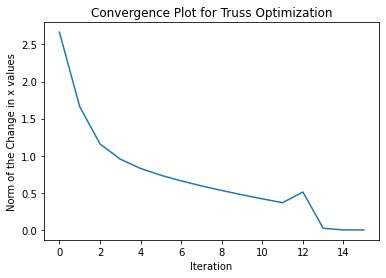

In [227]:
plt.plot(convergence[1:])
plt.title("Convergence Plot for Truss Optimization")
plt.xlabel("Iteration")
plt.ylabel("Norm of the Change in x values")